In [1]:
%load_ext cudf.pandas
%load_ext cuml.accel

[2025-10-10 13:07:55.390] [CUML] [info] cuML: Installed accelerator for sklearn.


2025-10-10 13:08:10.044882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760101690.292833      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760101690.365244      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[2025-10-10 13:08:30.242] [CUML] [info] cuML: Installed accelerator for umap.
[2025-10-10 13:08:30.327] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-10-10 13:08:30.327] [CUML] [info] cuML: Successfully initialized accelerator.


In [2]:
## -- IMPORT LIBRARIES -- ##
import torch
import sys
import os
import gc

import joblib
import pickle

## -- DATA MANIPUALATION --
import numpy as np
import pandas as pd
import random

## -- VISUALISATION --
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image

## -- FUNCTIONAL TOOLS --
from time import time
from google.colab import files
from tqdm.notebook import tqdm
from itertools import combinations

# ## SCIKIT-LEARN
import sklearn
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector as SFS1
from mlxtend.feature_selection import SequentialFeatureSelector as SFS2

# -- GBDTs --
import xgboost as xgb
import lightgbm as lgb
try:
    import catboost as cgb
    # import optuna
except:
    %pip install -qq -U catboost # optuna
    import catboost as cgb
    # import optuna

import warnings

In [3]:
np.__version__, pd.__version__, sns.__version__, sklearn.__version__

('1.26.4', '2.2.3', '0.12.2', '1.2.2')

In [4]:
## --- GLOBAL SETTINGS --- ##
sklearn.set_config(transform_output="pandas")

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
# pd.options.mode.copy_on_write = True
# plt.style.use("ggplot")

## -- Set Global Seed --
SEED = 42
def set_global_seed(seed = SEED):
    """Sets the global random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)

set_global_seed()

## -- Set Device-Agnostic code --
USE_cud = "cuda" if torch.cuda.is_available() else "cpu"
USE_gpu = "gpu" if torch.cuda.is_available() else "cpu"
USE_GPU = "GPU" if torch.cuda.is_available() else "CPU"

COLOR = '\033[32m'
RESET = '\033[0m'

In [5]:
## -- Load Data --
PATH = "/kaggle/input/playground-series-s5e10/"
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
orig = pd.read_csv("/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_100k.csv")
submit = pd.read_csv(PATH+"sample_submission.csv")

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

In [6]:
# ## -- Load Data --
# train= pd.read_csv("train.csv", index_col='id')
# test = pd.read_csv("test.csv", index_col='id')
# orig = pd.read_csv("synthetic_road_accidents_100k.csv")
# submit = pd.read_csv("sample_submission.csv")

# TARGET = "accident_risk"
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()
# FEATURES = NUMS + CATS

In [7]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
num_lanes,517754.0,2.491511,1.120434,1.0,1.00,2.00,3.00,4.0
curvature,517754.0,0.488719,0.272563,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,46.112575,15.788521,25.0,35.00,45.00,60.00,70.0
num_reported_accidents,517754.0,1.187970,0.895961,0.0,1.00,1.00,2.00,7.0
accident_risk,517754.0,0.352377,0.166417,0.0,0.23,0.34,0.46,1.0


In [9]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
num_lanes,172585.0,2.494046,1.119148,1.0,1.00,2.00,3.00,4.0
curvature,172585.0,0.487263,0.272343,0.0,0.26,0.51,0.71,1.0
speed_limit,172585.0,46.102761,15.787077,25.0,35.00,45.00,60.00,70.0
num_reported_accidents,172585.0,1.186059,0.897161,0.0,1.00,1.00,2.00,7.0


In [10]:
# Check if column names are the same regardless of order
are_same_set = set(train[FEATURES]) == set(test[FEATURES])
print(f"Are column names the same regardless of order (train vs test)? {are_same_set}")

# Check if column names are the same and in the same order
are_same_exact = train[FEATURES].equals(test[FEATURES])
print(f"Are column names exactly the same and in the same order (train vs test)? {are_same_exact}")

Are column names the same regardless of order (train vs test)? True
Are column names exactly the same and in the same order (train vs test)? False


In [11]:
## -- Unique value counts per dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in test.columns:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='Spectral')

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
Train,3,4,261,5,3,3,2,2,3,2,2,8
Original,3,4,101,5,3,3,2,2,3,2,2,11
Test,3,4,195,5,3,3,2,2,3,2,2,8


### FEATURE ENGINEERING

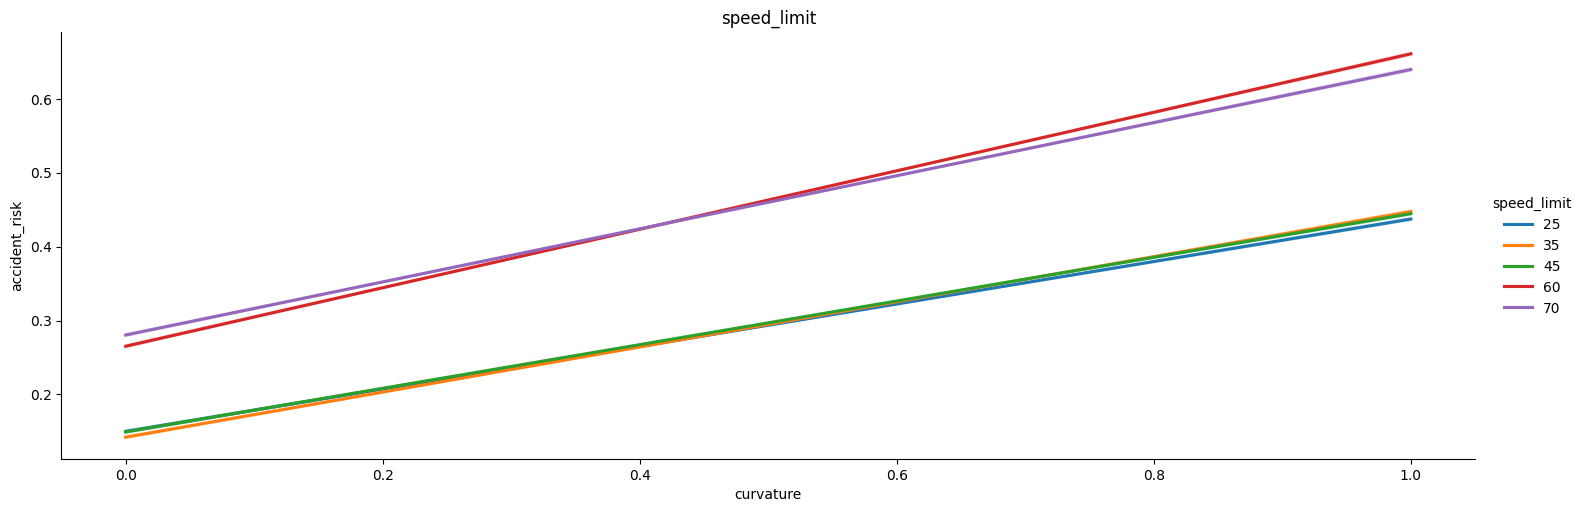

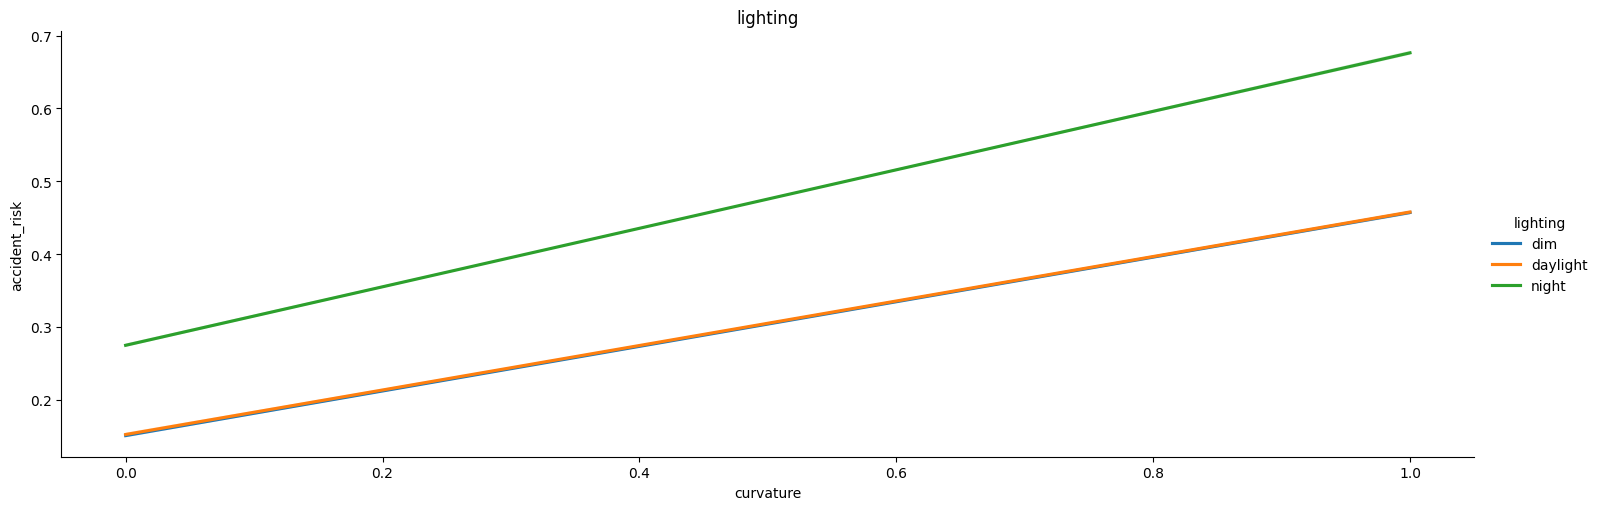

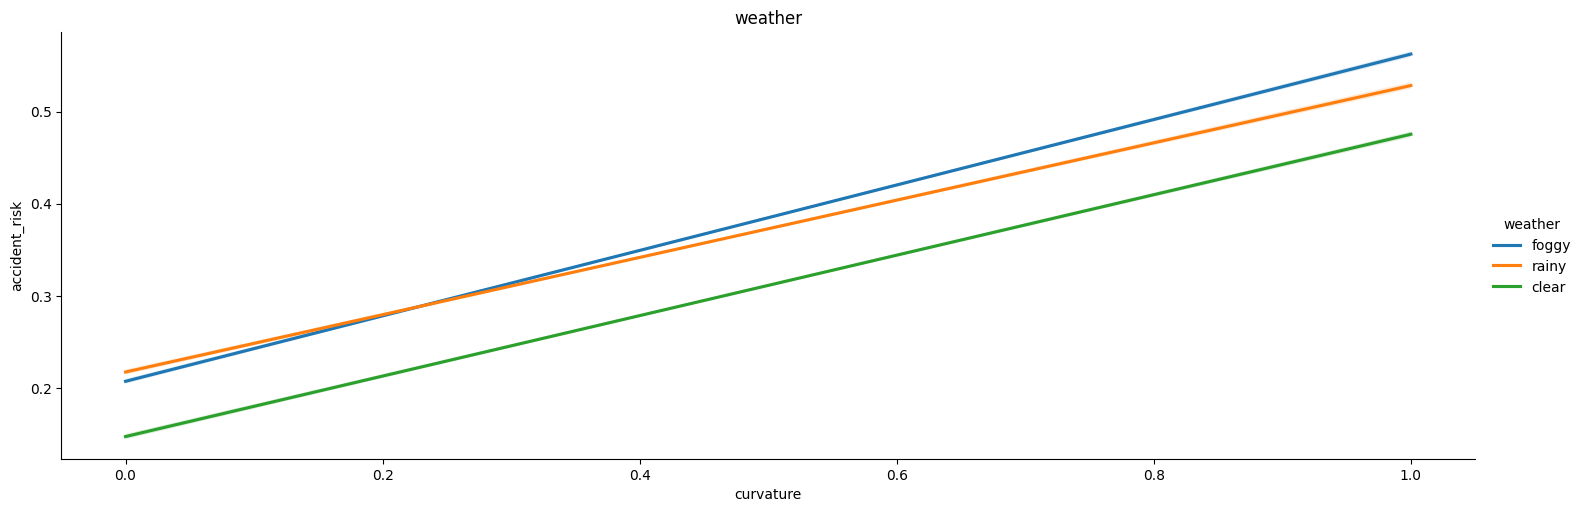

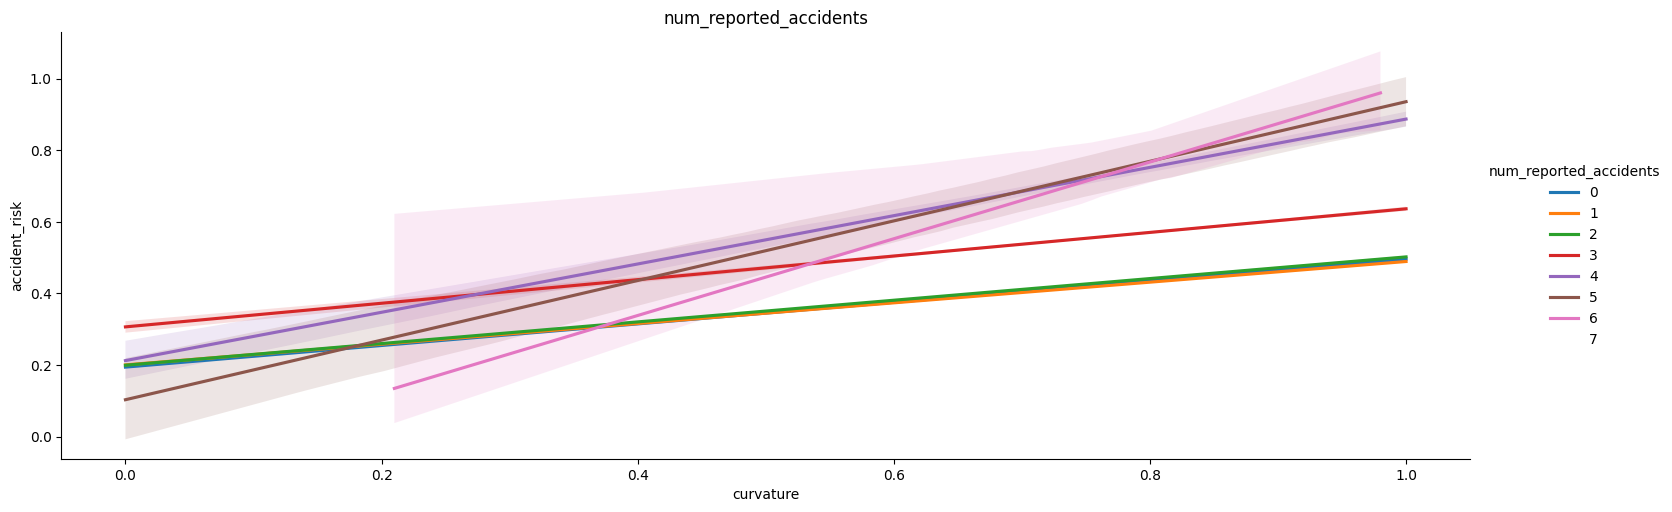

In [12]:
for col in ['speed_limit','lighting','weather','num_reported_accidents']:
    sns.lmplot(train.sample(frac=0.2), x='curvature', y=TARGET, hue=col,
               scatter=False, aspect=3.0, seed=SEED)
    plt.title(col)
    plt.show() 

In [13]:
## -- CREATE FEATURES -- ##
def create_features(train, test, orig):

    ## -- FEATURE 1: Use original as features
    print(f"Merging {len(FEATURES)} features... ", end="")
    ORIG_FEATURES = []
    for c in FEATURES:
        tmp = orig.groupby(c)[TARGET].mean()
        n = f"orig_{c}"
        print(f"{n}, ", end="")
        tmp.name = n
        train = train.merge(tmp, on=c, how='left')
        test  = test.merge(tmp, on=c, how='left')

        ORIG_FEATURES.append(n)

    print()

    df = pd.concat([train, test], ignore_index=True)

    for col in CATS:
        df[col], _ = pd.factorize(df[col])

    df['curvature_bin'] = pd.cut(df['curvature'], bins=np.linspace(0, 1, 5), include_lowest=True, labels=False)
    df['curvature_sqrt'] = np.sqrt(df['curvature']) # Square-root
    df['curvature_squared'] = df['curvature'] ** 2 # Squared
    df['curvature_cubed'] = df['curvature'] ** 3 # Cubed
    df['curve+speed+light'] = df[['curvature', 'speed_limit', 'lighting']].sum(axis=1)
    print(f"✅ Polynomial features created!")

    # # high_risk according to the binary rules (0, 1)
    # mask = (
    #         # (df['curvature'] >= 0.5) &
    #         (df['speed_limit'] >= 60) &
    #         (df['lighting'] == 'night') &
    #         (df['weather'] != 'clear')
    #         # & (df['num_reported_accidents'] > 2)
    #     )
    # df['high_risk'] = mask.astype("int8")
    # print(f"✅ 'high_risk' feature created!")

    # meta feature according to level rules (0.0 to 1.0)
    base_risk = (
            0.3 * df["curvature"] +
            0.2 * (df["lighting"] == "night").astype(int) +
            0.1 * (df["weather"] != "clear").astype(int) +
            0.2 * (df["speed_limit"] >= 60).astype(int) +
            0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
        )
    df['meta'] = base_risk

    print(f"✅ 'meta' feature created!")

    train = df.iloc[:len(train)].reset_index(drop=True)
    test  = df.iloc[len(train):].drop(TARGET, axis=1).reset_index(drop=True)

    ## -- Pairwise combinations --
    TE_2 = []
    for n in [2]:
        for cols in tqdm(list(combinations(FEATURES, n)), desc="Creating Pairwise"):
            name = '-'.join(sorted(cols))

            # Create combos by concatenating string representations
            train[name] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
            test[name] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)

            # Fit the category encoder ONLY on the training data
            train[name] = train[name].astype('category')
            cat = train[name].cat
            # Apply consistent encoding across datasets
            train[name] = train[name].cat.codes
            # Use the fitted category to transform the test set
            test[name] = pd.Categorical(test[name], categories=cat.categories).codes

            TE_2.append(name)

    ## -- Triplewise combinations --
    TE_3 = []
    TOP_PREDICTORS = ['curvature','speed_limit','lighting','weather','num_reported_accidents']

    for n in [3]:
        for cols in tqdm(list(combinations(TOP_PREDICTORS, n)), desc="Creating Triplewise"):
            nm = '-'.join(sorted(cols))
            train[nm] = train[cols[0]].astype(str) + '_' + \
                        train[cols[1]].astype(str) + '_' + \
                        train[cols[2]].astype(str)
            test[nm ] = test[cols[0]].astype(str) + '_' + \
                        test[cols[1]].astype(str) + '_' + \
                        test[cols[2]].astype(str)

            train[nm] = train[nm].astype('category')
            cat = train[nm].cat
            train[nm] = train[nm].cat.codes
            test[nm] = pd.Categorical(test[nm], categories=cat.categories).codes

            TE_3.append(name)

    TE = TE_2+TE_3

    print(f"✅ Interations (TE) created: {len(TE)}")
    print(f"{COLOR}{'='*50}")
    print(f"ℹ️ Feature Engineering Complete!")
    print(f"ℹ️ Total features: {len(test.columns)}")
    print(f"{'='*50}")

    return train, test, TE

In [14]:
train, test, TE = create_features(train, test, orig)

Merging 12 features... orig_num_lanes, orig_curvature, orig_speed_limit, orig_num_reported_accidents, orig_road_type, orig_lighting, orig_weather, orig_road_signs_present, orig_public_road, orig_time_of_day, orig_holiday, orig_school_season, 
✅ Polynomial features created!
✅ 'meta' feature created!


Creating Pairwise:   0%|          | 0/66 [00:00<?, ?it/s]

Creating Triplewise:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Interations (TE) created: 76
ℹ️ Feature Engineering Complete!
ℹ️ Total features: 106


In [15]:
train.meta.nunique(), #train.high_risk.nunique()

(577,)

In [16]:
# sns.lmplot(train.sample(frac=0.2), x='curvature', y=TARGET, hue='high_risk', aspect=3.0)
# plt.show()

In [17]:
display(train.head())
display(train.info())
train.shape, test.shape

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,orig_num_lanes,orig_curvature,orig_speed_limit,orig_num_reported_accidents,orig_road_type,orig_lighting,orig_weather,orig_road_signs_present,orig_public_road,orig_time_of_day,orig_holiday,orig_school_season,curvature_bin,curvature_sqrt,curvature_squared,curvature_cubed,curve+speed+light,meta,curvature-num_lanes,num_lanes-speed_limit,num_lanes-num_reported_accidents,num_lanes-road_type,lighting-num_lanes,num_lanes-weather,num_lanes-road_signs_present,num_lanes-public_road,num_lanes-time_of_day,holiday-num_lanes,num_lanes-school_season,curvature-speed_limit,curvature-num_reported_accidents,curvature-road_type,curvature-lighting,curvature-weather,curvature-road_signs_present,curvature-public_road,curvature-time_of_day,curvature-holiday,curvature-school_season,num_reported_accidents-speed_limit,road_type-speed_limit,lighting-speed_limit,speed_limit-weather,road_signs_present-speed_limit,public_road-speed_limit,speed_limit-time_of_day,holiday-speed_limit,school_season-speed_limit,num_reported_accidents-road_type,lighting-num_reported_accidents,num_reported_accidents-weather,num_reported_accidents-road_signs_present,num_reported_accidents-public_road,num_reported_accidents-time_of_day,holiday-num_reported_accidents,num_reported_accidents-school_season,lighting-road_type,road_type-weather,road_signs_present-road_type,public_road-road_type,road_type-time_of_day,holiday-road_type,road_type-school_season,lighting-weather,lighting-road_signs_present,lighting-public_road,lighting-time_of_day,holiday-lighting,lighting-school_season,road_signs_present-weather,public_road-weather,time_of_day-weather,holiday-weather,school_season-weather,public_road-road_signs_present,road_signs_present-time_of_day,holiday-road_signs_present,road_signs_present-school_season,public_road-time_of_day,holiday-public_road,public_road-school_season,holiday-time_of_day,school_season-time_of_day,holiday-school_season,curvature-lighting-speed_limit,curvature-speed_limit-weather,curvature-num_reported_accidents-speed_limit,curvature-lighting-weather,curvature-lighting-num_reported_accidents,curvature-num_reported_accidents-weather,lighting-speed_limit-weather,lighting-num_reported_accidents-speed_limit,num_reported_accidents-speed_limit-weather,lighting-num_reported_accidents-weather
0,0,2,0.06,35,0,0,0,0,0,0,0,1,0.13,0.383314,0.258877,0.302913,0.362839,0.383005,0.317187,0.416192,0.382532,0.381794,0.382933,0.383271,0.382336,0,0.244949,0.0036,0.000216,35.06,0.118,157,6,8,3,3,3,2,2,3,2,2,27,32,16,16,16,11,11,16,11,11,8,3,3,3,2,2,3,2,2,3,3,3,2,2,3,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79,79,137,46,85,85,9,20,21,1
1,0,4,0.99,35,0,1,1,1,1,1,0,0,0.35,0.383017,0.524931,0.302913,0.364235,0.383005,0.317187,0.316435,0.382693,0.383427,0.383150,0.381964,0.382336,3,0.994987,0.9801,0.970299,35.99,0.397,640,16,23,9,9,10,7,7,10,7,6,721,796,521,495,499,402,399,516,397,396,7,3,3,4,3,3,4,3,2,0,0,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,0,3,3,4,3,2,3,4,3,2,4,3,2,3,2,2,1726,1735,2663,1121,1758,1787,10,19,27,7
2,1,4,0.63,70,1,1,0,0,2,1,1,2,0.30,0.383017,0.430585,0.502361,0.363362,0.382544,0.316984,0.316435,0.382532,0.381794,0.381756,0.381964,0.382888,2,0.793725,0.3969,0.250047,71.63,0.489,604,19,25,10,10,10,6,6,11,7,7,540,571,410,385,387,325,323,406,321,322,31,13,13,13,8,8,14,9,9,7,7,7,4,4,8,5,5,4,4,2,2,5,3,3,4,2,2,5,3,3,2,2,5,3,3,0,2,1,1,2,1,1,5,5,3,1192,1200,1736,796,1185,1175,40,88,87,31
3,2,4,0.07,35,1,0,1,0,2,0,1,1,0.21,0.383017,0.246063,0.302913,0.362839,0.382288,0.316984,0.416192,0.382693,0.381794,0.381756,0.383271,0.382888,0,0.264575,0.0049,0.000343,36.07,0.121,480,16,24,11,10,9,7,6,11,6,7,32,38,21,20,19,14,13,21,13,14,8,5,4,3,3,2,5,2,3,5,4,3,3,2,5,2,3,7,6,5,4,8,4,5,3,3,2,5,2,3,1,0,2,0,1,2,5,2,3,2,0,1,4,5,1,95,94,161,58,107,100,12,27,21,23
4,1,1,0.58,60,0,2,0,1,1,1,1,1,0.56,0.381536,0.408129,0.502156,0.3628

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Columns: 107 entries, road_type to lighting-num_reported_accidents-weather
dtypes: float64(19), int64(12), uint16(17), uint8(59)
memory usage: 168.5 MB


None

((517754, 107), (172585, 106))

### MODEL TRAINING

In [18]:
# %%capture
if USE_cud == 'cuda':
    import cuml
    from cuml.preprocessing import TargetEncoder as cuTE
else:
    try:
        import category_encoders as ce
        # import sktools as sk
    except:
        %pip install -qq -U category_encoders #sktools
        import category_encoders as ce
        # import sktools as sk

|------------------------------
	Fold 1 #####


Target Encoding:   0%|          | 0/76 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16538
[100]	validation_0-rmse:0.10966
[200]	validation_0-rmse:0.07995
[300]	validation_0-rmse:0.06575
[400]	validation_0-rmse:0.05968
[500]	validation_0-rmse:0.05729
[600]	validation_0-rmse:0.05639
[700]	validation_0-rmse:0.05606
[800]	validation_0-rmse:0.05593
[900]	validation_0-rmse:0.05589
[1000]	validation_0-rmse:0.05587
[1100]	validation_0-rmse:0.05586
[1200]	validation_0-rmse:0.05585
[1300]	validation_0-rmse:0.05585
[1400]	validation_0-rmse:0.05585
[1500]	validation_0-rmse:0.05585
[1600]	validation_0-rmse:0.05585
[1700]	validation_0-rmse:0.05585
[1800]	validation_0-rmse:0.05585
[1896]	validation_0-rmse:0.05585
	RMSE Score: 0.055846
|------------------------------
	Fold 2 #####


Target Encoding:   0%|          | 0/76 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16550
[100]	validation_0-rmse:0.11018
[200]	validation_0-rmse:0.08068
[300]	validation_0-rmse:0.06652
[400]	validation_0-rmse:0.06042
[500]	validation_0-rmse:0.05797
[600]	validation_0-rmse:0.05701
[700]	validation_0-rmse:0.05663
[800]	validation_0-rmse:0.05648
[900]	validation_0-rmse:0.05641
[1000]	validation_0-rmse:0.05638
[1100]	validation_0-rmse:0.05637
[1200]	validation_0-rmse:0.05636
[1300]	validation_0-rmse:0.05636
[1400]	validation_0-rmse:0.05636
[1500]	validation_0-rmse:0.05635
[1600]	validation_0-rmse:0.05635
[1700]	validation_0-rmse:0.05635
[1800]	validation_0-rmse:0.05635
[1900]	validation_0-rmse:0.05635
[2000]	validation_0-rmse:0.05635
[2100]	validation_0-rmse:0.05635
[2200]	validation_0-rmse:0.05635
[2224]	validation_0-rmse:0.05635
	RMSE Score: 0.056352
|------------------------------
	Fold 3 #####


Target Encoding:   0%|          | 0/76 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16483
[100]	validation_0-rmse:0.10947
[200]	validation_0-rmse:0.08000
[300]	validation_0-rmse:0.06593
[400]	validation_0-rmse:0.05992
[500]	validation_0-rmse:0.05755
[600]	validation_0-rmse:0.05665
[700]	validation_0-rmse:0.05630
[800]	validation_0-rmse:0.05617
[900]	validation_0-rmse:0.05612
[1000]	validation_0-rmse:0.05610
[1100]	validation_0-rmse:0.05609
[1200]	validation_0-rmse:0.05609
[1300]	validation_0-rmse:0.05608
[1400]	validation_0-rmse:0.05608
[1500]	validation_0-rmse:0.05608
[1600]	validation_0-rmse:0.05608
[1700]	validation_0-rmse:0.05608
[1800]	validation_0-rmse:0.05608
[1900]	validation_0-rmse:0.05608
[2000]	validation_0-rmse:0.05608
[2035]	validation_0-rmse:0.05608
	RMSE Score: 0.056075
|------------------------------
	Fold 4 #####


Target Encoding:   0%|          | 0/76 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16661
[100]	validation_0-rmse:0.11057
[200]	validation_0-rmse:0.08061
[300]	validation_0-rmse:0.06617
[400]	validation_0-rmse:0.05993
[500]	validation_0-rmse:0.05743
[600]	validation_0-rmse:0.05645
[700]	validation_0-rmse:0.05607
[800]	validation_0-rmse:0.05591
[900]	validation_0-rmse:0.05585
[1000]	validation_0-rmse:0.05582
[1100]	validation_0-rmse:0.05581
[1200]	validation_0-rmse:0.05580
[1300]	validation_0-rmse:0.05580
[1400]	validation_0-rmse:0.05580
[1500]	validation_0-rmse:0.05580
[1600]	validation_0-rmse:0.05579
[1700]	validation_0-rmse:0.05580
[1800]	validation_0-rmse:0.05580
[1885]	validation_0-rmse:0.05580
	RMSE Score: 0.055795
|------------------------------
	Fold 5 #####


Target Encoding:   0%|          | 0/76 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16650
[100]	validation_0-rmse:0.11055
[200]	validation_0-rmse:0.08069
[300]	validation_0-rmse:0.06635
[400]	validation_0-rmse:0.06019
[500]	validation_0-rmse:0.05773
[600]	validation_0-rmse:0.05678
[700]	validation_0-rmse:0.05642
[800]	validation_0-rmse:0.05628
[900]	validation_0-rmse:0.05622
[1000]	validation_0-rmse:0.05620
[1100]	validation_0-rmse:0.05619
[1200]	validation_0-rmse:0.05618
[1300]	validation_0-rmse:0.05618
[1400]	validation_0-rmse:0.05618
[1500]	validation_0-rmse:0.05618
[1600]	validation_0-rmse:0.05618
[1700]	validation_0-rmse:0.05618
[1766]	validation_0-rmse:0.05618
	RMSE Score: 0.056176
|------------------------------
	Fold 6 #####


Target Encoding:   0%|          | 0/76 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16580
[100]	validation_0-rmse:0.11002
[200]	validation_0-rmse:0.08026
[300]	validation_0-rmse:0.06599
[400]	validation_0-rmse:0.05987
[500]	validation_0-rmse:0.05744
[600]	validation_0-rmse:0.05651
[700]	validation_0-rmse:0.05615
[800]	validation_0-rmse:0.05602
[900]	validation_0-rmse:0.05596
[1000]	validation_0-rmse:0.05594
[1100]	validation_0-rmse:0.05593
[1200]	validation_0-rmse:0.05592
[1300]	validation_0-rmse:0.05592
[1400]	validation_0-rmse:0.05592
[1500]	validation_0-rmse:0.05592
[1600]	validation_0-rmse:0.05592
[1700]	validation_0-rmse:0.05592
[1800]	validation_0-rmse:0.05592
[1900]	validation_0-rmse:0.05592
[2000]	validation_0-rmse:0.05592
[2100]	validation_0-rmse:0.05592
[2182]	validation_0-rmse:0.05592
	RMSE Score: 0.055917
|------------------------------
	Fold 7 #####


Target Encoding:   0%|          | 0/76 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16540
[100]	validation_0-rmse:0.10988
[200]	validation_0-rmse:0.08027
[300]	validation_0-rmse:0.06607
[400]	validation_0-rmse:0.05996
[500]	validation_0-rmse:0.05752
[600]	validation_0-rmse:0.05657
[700]	validation_0-rmse:0.05621
[800]	validation_0-rmse:0.05606
[900]	validation_0-rmse:0.05600
[1000]	validation_0-rmse:0.05598
[1100]	validation_0-rmse:0.05597
[1200]	validation_0-rmse:0.05596
[1300]	validation_0-rmse:0.05596
[1400]	validation_0-rmse:0.05596
[1500]	validation_0-rmse:0.05596
[1600]	validation_0-rmse:0.05596
[1657]	validation_0-rmse:0.05596
	RMSE Score: 0.055960
|------------------------------
	Fold 8 #####


Target Encoding:   0%|          | 0/76 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16515
[100]	validation_0-rmse:0.10951
[200]	validation_0-rmse:0.07985
[300]	validation_0-rmse:0.06566
[400]	validation_0-rmse:0.05961
[500]	validation_0-rmse:0.05722
[600]	validation_0-rmse:0.05631
[700]	validation_0-rmse:0.05596
[800]	validation_0-rmse:0.05584
[900]	validation_0-rmse:0.05578
[1000]	validation_0-rmse:0.05576
[1100]	validation_0-rmse:0.05576
[1200]	validation_0-rmse:0.05575
[1300]	validation_0-rmse:0.05575
[1400]	validation_0-rmse:0.05575
[1500]	validation_0-rmse:0.05575
[1600]	validation_0-rmse:0.05575
[1700]	validation_0-rmse:0.05575
[1800]	validation_0-rmse:0.05575
[1900]	validation_0-rmse:0.05575
[1901]	validation_0-rmse:0.05575
	RMSE Score: 0.055748
|------------------------------
	Fold 9 #####


Target Encoding:   0%|          | 0/76 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16606
[100]	validation_0-rmse:0.11016
[200]	validation_0-rmse:0.08027
[300]	validation_0-rmse:0.06588
[400]	validation_0-rmse:0.05967
[500]	validation_0-rmse:0.05719
[600]	validation_0-rmse:0.05622
[700]	validation_0-rmse:0.05584
[800]	validation_0-rmse:0.05569
[900]	validation_0-rmse:0.05563
[1000]	validation_0-rmse:0.05561
[1100]	validation_0-rmse:0.05560
[1200]	validation_0-rmse:0.05559
[1300]	validation_0-rmse:0.05559
[1400]	validation_0-rmse:0.05558
[1500]	validation_0-rmse:0.05558
[1600]	validation_0-rmse:0.05558
[1700]	validation_0-rmse:0.05558
[1792]	validation_0-rmse:0.05558
	RMSE Score: 0.055583
|------------------------------
	Fold 10 #####


Target Encoding:   0%|          | 0/76 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16558
[100]	validation_0-rmse:0.10995
[200]	validation_0-rmse:0.08030
[300]	validation_0-rmse:0.06607
[400]	validation_0-rmse:0.05996
[500]	validation_0-rmse:0.05752
[600]	validation_0-rmse:0.05658
[700]	validation_0-rmse:0.05622
[800]	validation_0-rmse:0.05607
[900]	validation_0-rmse:0.05602
[1000]	validation_0-rmse:0.05599
[1100]	validation_0-rmse:0.05598
[1200]	validation_0-rmse:0.05597
[1300]	validation_0-rmse:0.05597
[1400]	validation_0-rmse:0.05597
[1500]	validation_0-rmse:0.05597
[1600]	validation_0-rmse:0.05597
[1700]	validation_0-rmse:0.05597
[1800]	validation_0-rmse:0.05597
[1900]	validation_0-rmse:0.05597
[2000]	validation_0-rmse:0.05597
[2100]	validation_0-rmse:0.05597
[2200]	validation_0-rmse:0.05597
[2290]	validation_0-rmse:0.05597
	RMSE Score: 0.055967
|----------------------------------------------------
|  Overall OOF RMSE: 0.055942
| Average Fold RMSE: 0.055942 ± 0.000210


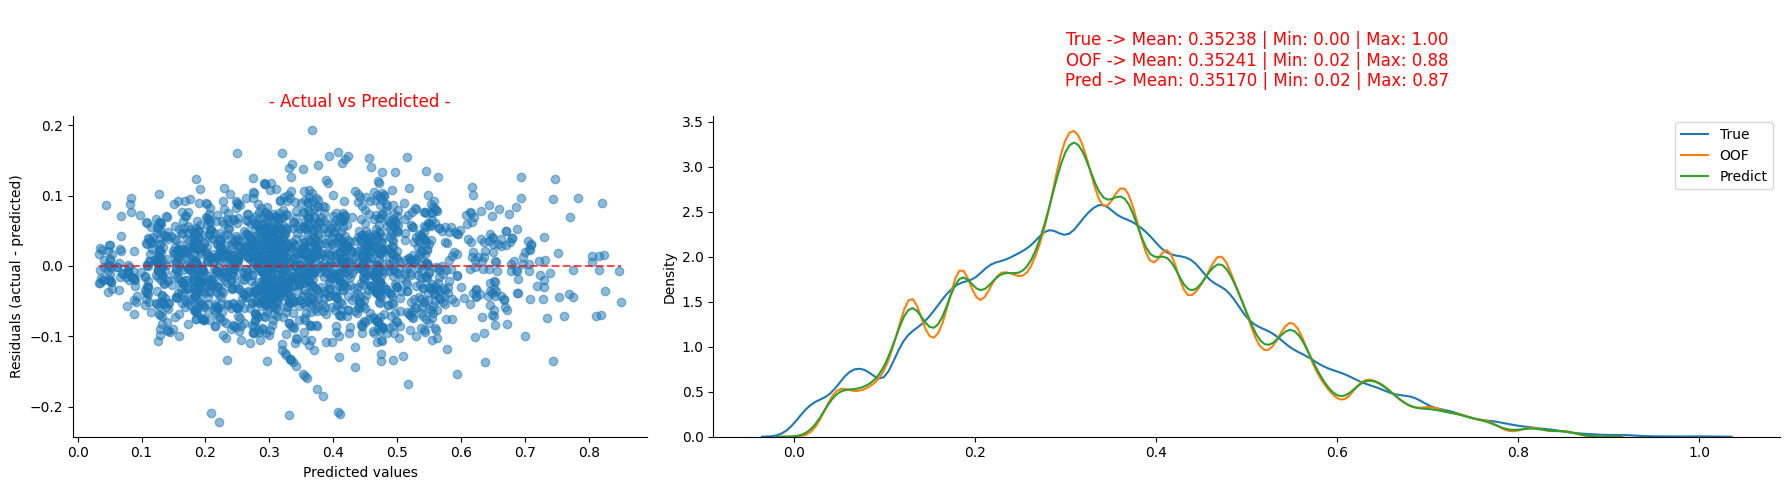

Computation Time: 1174.86 secs ##########################################################################################


In [19]:
## -- DEFINE TRAINING PARAMETERS -- ##
## -----------------------------------------------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true.values, y_pred))

## -- Initiate Training -- ##
oof_preds   = np.zeros(len(train))
test_preds  = np.zeros(len(test))
fold_Scores = []

X = train.drop(TARGET, axis=1)
y = train[TARGET]

FOLDS = 10
REPEATS = 2

# kf = RepeatedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

tik = time()
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"|{'-'*30}")
    print(f"\t{COLOR}Fold {fold} {'#'*5}{RESET}")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    X_train_enc = X_train_fold.copy()
    X_val_enc   = X_val_fold.copy()
    test_enc    = test.copy()

    ## -- TARGET ENCODING --
    for col in tqdm(TE, desc="Target Encoding", leave=False):
        if USE_cud == 'cuda': #-> GPU
            TE_enc = cuTE(n_folds=10, smooth=10, split_method='random')
        else: #-> CPU
            TE_enc = ce.TargetEncoder(cols=[col], smoothing=10)
        n = f"TE_{col}"
        X_train_enc[n] = TE_enc.fit_transform(X_train_enc[col], y_train_fold).astype('float32')
        X_val_enc[n]   = TE_enc.transform(X_val_enc[col]).astype('float32')
        test_enc[n]    = TE_enc.transform(test_enc[col]).astype('float32')

        # X_train_enc = X_train_enc.drop(col, axis=1)
        # X_val_enc   = X_val_enc.drop(col, axis=1)
        # test_enc    = test_enc.drop(col, axis=1)

    ## -- Instantiate model -- ##
    params = dict(
                grow_policy = "depthwise",
                eval_metric = "rmse",
                early_stopping_rounds = 300,
                n_estimators = 8000,
                eta = 0.005,
                max_depth = 8,
                subsample = 0.8,
                colsample_bytree = 0.5,
                reg_alpha = 0.001,
                reg_lambda = 1.0,
                min_child_weight = 5,
                verbosity = 0,
                n_jobs = -1,
                random_state = SEED + fold,
                device = USE_cud,
        )
    model = xgb.XGBRegressor(**params)
    model.fit(
            X_train_enc, y_train_fold,
            eval_set = [(X_val_enc, y_val_fold)],
            verbose  = 100,
        )
    y_fold_pred = model.predict(X_val_enc, iteration_range=(0, model.best_iteration+1))
    oof_preds[val_idx] = np.clip(y_fold_pred, 0.0, 1.0)
    predictions = model.predict(test_enc, iteration_range=(0, model.best_iteration+1))
    test_preds += np.clip(predictions, 0.0, 1.0) / FOLDS #* REPEATS

    ## -- Compute RMSE for validation fold
    fold_rmse = rmse(y_val_fold, y_fold_pred)
    fold_Scores.append(fold_rmse)
    print(f"\t{COLOR}RMSE Score: {fold_rmse:.6f}{RESET}")
    gc.collect()

## -- After all folds --
overall_RMSE = rmse(y, oof_preds)
print(f"|{'-'*52}")
print(f"{COLOR}|  Overall OOF RMSE: {overall_RMSE:.6f}")
print(f"| Average Fold RMSE: {np.mean(fold_Scores):.6f} ± {np.std(fold_Scores):.6f}{RESET}")

## -- Plot predictions errors --
fig, axs = plt.subplots(1, 2, figsize = (18, 5), width_ratios=[0.35, 0.65])
display = PredictionErrorDisplay.from_predictions(
                y, oof_preds, ax = axs[0],
                # kind = "actual_vs_predicted",
                subsample = 2000,
                scatter_kwargs = {"alpha": 0.5},
                line_kwargs = {'color': 'r'},
        )
axs[0].set_title(f"- Actual vs Predicted -", color='r')
LABELS = ['True', 'OOF', 'Predict']
sns.kdeplot(y.values, ax=axs[1], label=LABELS[0])
sns.kdeplot(oof_preds, ax=axs[1], label=LABELS[1])
sns.kdeplot(test_preds, ax=axs[1], label=LABELS[2])
axs[1].set_title(f"""
    True -> Mean: {np.mean(y.values):.5f} | Min: {np.min(y.values):.2f} | Max: {np.max(y.values):.2f}
    OOF -> Mean: {np.mean(oof_preds):.5f} | Min: {np.min(oof_preds):.2f} | Max: {np.max(oof_preds):.2f}
    Pred -> Mean: {np.mean(test_preds):.5f} | Min: {np.min(test_preds):.2f} | Max: {np.max(test_preds):.2f}
        """, color='r')

for ax in axs:
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.show()

name = f"xgb{np.mean(fold_Scores):.6f}"
oof_final  = pd.DataFrame(oof_preds, columns=[name])
test_final = pd.DataFrame(test_preds, columns=[name])

tok = time()
tiktok = tok-tik
print(f"Computation Time: {tiktok:.2f} secs {'#'*90}")

In [20]:
test_final
# oof_final.shape, test_final.shape

,xgb0.055942
0,0.294765
1,0.122656
2,0.179789
3,0.313297
4,0.407161
...,...
172580,0.104891
172581,0.517523
172582,0.247951
172583,0.127353


In [21]:
## -- Export OOF & PREDICTIONS files -- ##
oof_final.to_parquet(f"{name}_oof.parquet", index=False)
test_final.to_parquet(f"{name}_pred.parquet", index=False)

In [22]:
submit[TARGET] = test_final.values
submit.to_csv(f"submit_{name}.csv", index=False)
submit.head()

,id,accident_risk
0,517754,0.294765
1,517755,0.122656
2,517756,0.179789
3,517757,0.313297
4,517758,0.407161


In [23]:
X_val_enc.shape

(51775, 172)

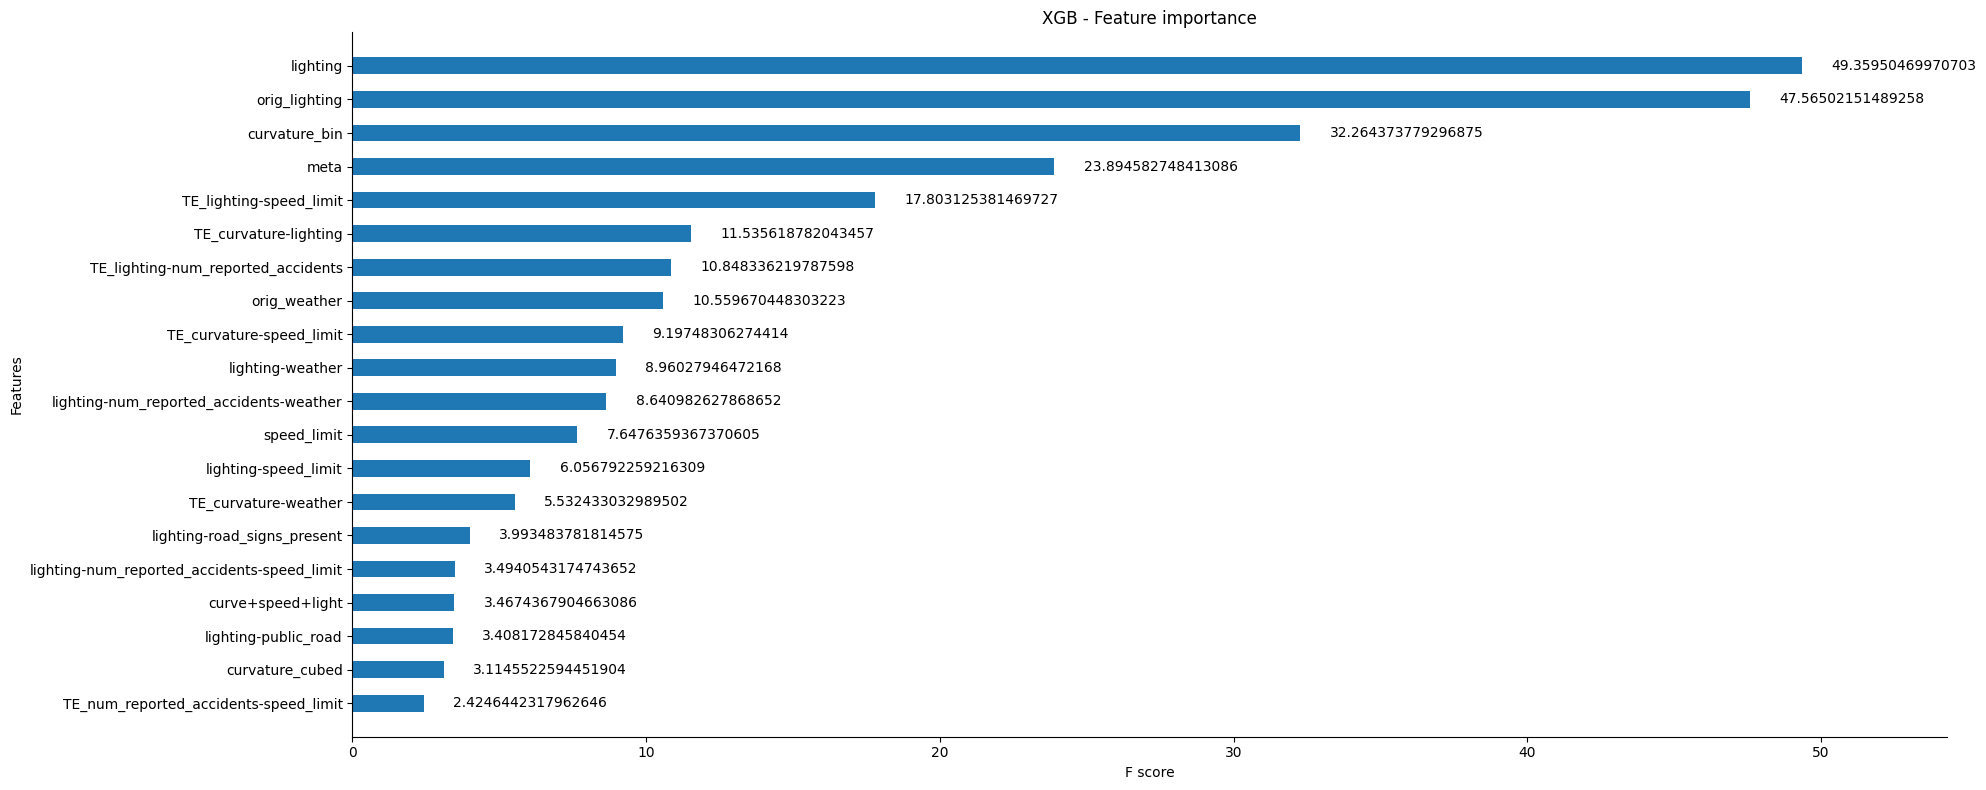

In [24]:
## -- Plot Feature Importances --
MAX = 20
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
xgb.plot_importance(
                    model, ax=ax,
                    importance_type='gain',
                    grid=False, height=0.5,
                    # show_values=False,
                    max_num_features=20,
                    title="XGB - Feature importance"
    )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [25]:
# Install in terminal/console
!pip install --upgrade -qq shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.1 MB/s eta 0:00:00


100%|===================| 998/1000 [03:38<00:00]       

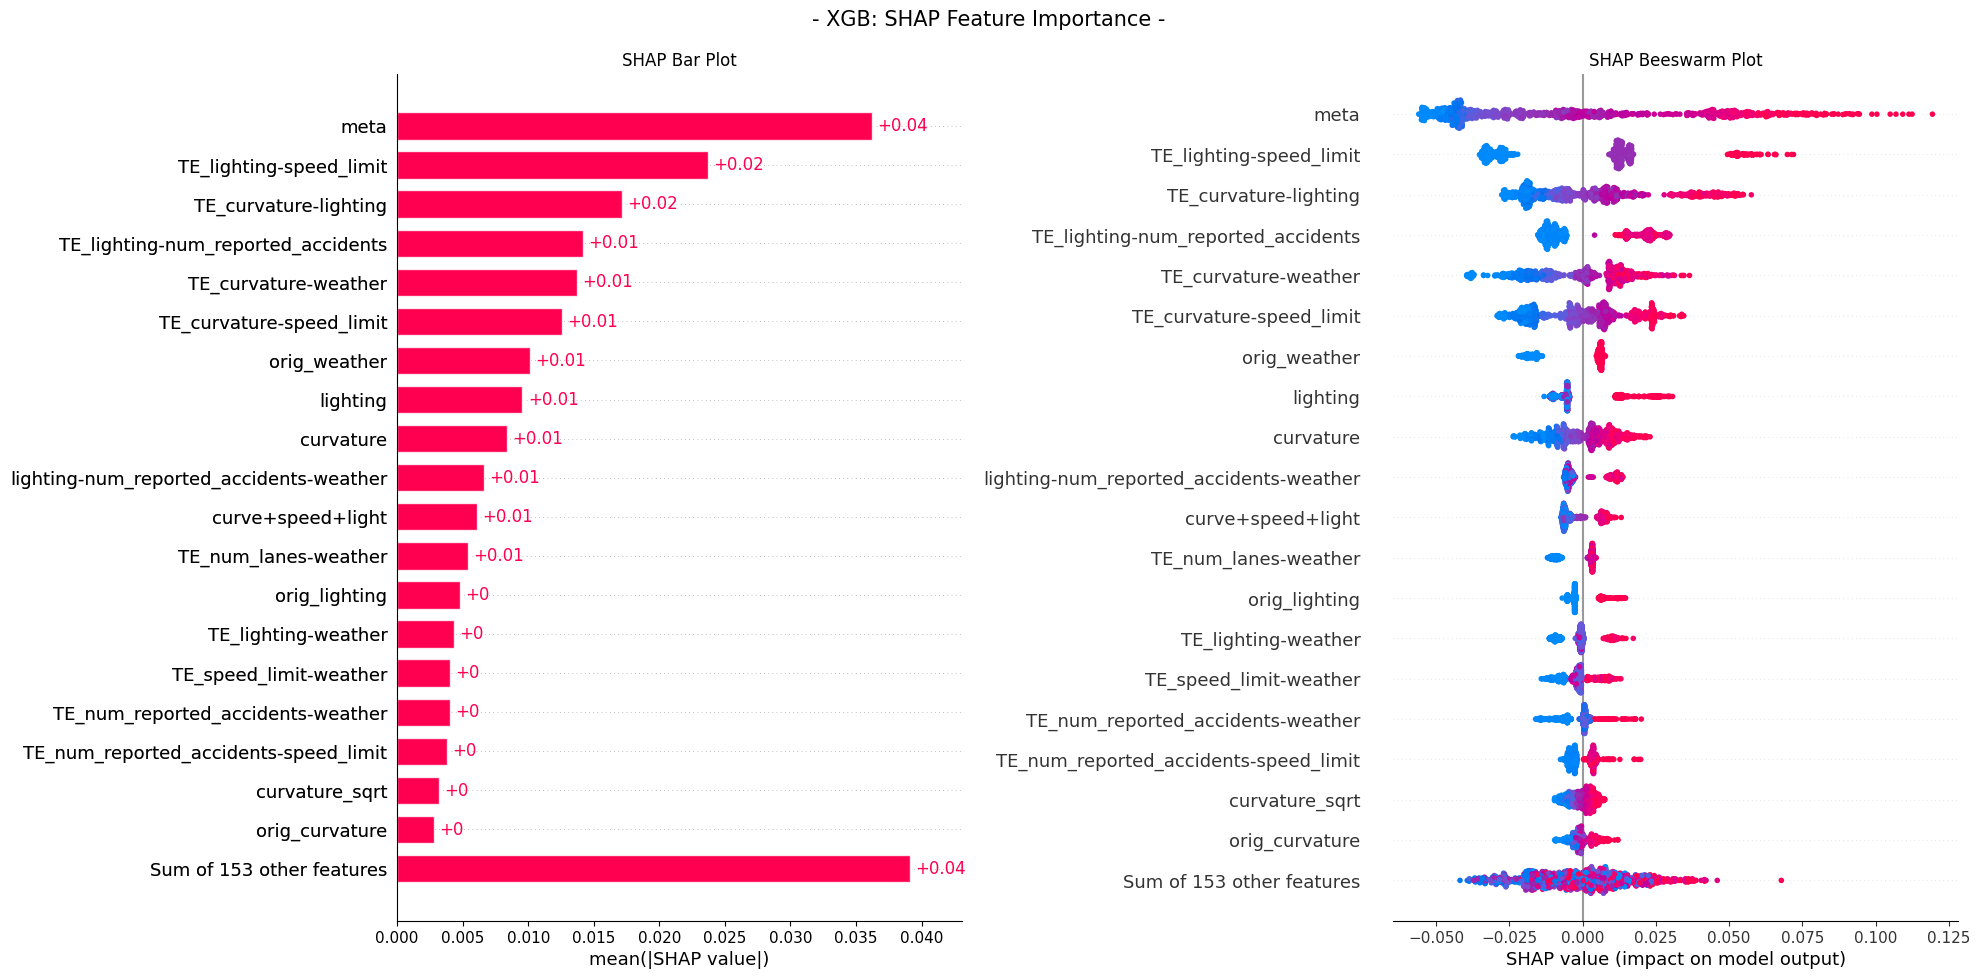

In [26]:
## -- Plot SHAP --
fig, axs =  plt.subplots(1, 2, figsize=(20, 10))

explainer = shap.TreeExplainer(model, X_train_enc)
shap_values = explainer(X_val_enc.sample(1000))

# Bar plot
shap.plots.bar(shap_values, show=False, max_display=MAX, ax=axs[0])
axs[0].set_title("SHAP Bar Plot")
# Beeswarm plot
shap.plots.beeswarm(shap_values, show=False, max_display=MAX, ax=axs[1], color_bar=False, plot_size=None)
axs[1].set_title("SHAP Beeswarm Plot")
fig.suptitle(f"- XGB: SHAP Feature Importance -", fontsize=15)
fig.tight_layout(pad=1.5)
plt.show()

In [27]:
# ## -- GPU FORWARD FEATURE SELECTION -- ##
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# ADD  = []
# best_rmse = 0
# best_oof = None
# best_pred = None

# FOLDS = 5
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# X = train.drop(TARGET, axis=1)
# y = train[TARGET]

# # FORWARD FEATURE SELECTION
# for k, col in enumerate(['baseline']+TE_columns, start=1):
#     oof_cuRF = np.zeros(len(X))
#     pred_cuRF = np.zeros(len(test))
#     # scaler = RobustScaler()
#     encoder = ce.TargetEncoder(cols=col, smoothing=10)

#     if col != 'baseline': ADD.append(col)

#     # K-FOLD USING YEAR AS GROUP
#     for i, (train_index, test_index) in enumerate(kf.split(X)):
#         # TRAIN AND VALID DATA
#         x_train = X.loc[train_index, ['TrackDurationMs']+ADD].copy()
#         y_train = y.loc[train_index]
#         x_valid = X.loc[test_index, ['TrackDurationMs']+ADD].copy()
#         y_valid = y.loc[test_index]
#         x_test = test[['TrackDurationMs']+ADD].copy()

#         # x_train = scaler.fit_transform(x_train)
#         # x_valid = scaler.transform(x_valid)

#         if col != 'baseline':
#             encoder.fit(x_train, y_train)
#             x_train = encoder.transform(x_train)
#             x_valid = encoder.transform(x_valid)

#         # # SVC WANTS STANDARIZED FEATURES
#         # for c in ORIG_FEATURES+ADD:
#         #     m = x_train[c].mean()
#         #     s = x_train[c].std()
#         #     x_train[c] = (x_train[c]#-m)/s
#         #     x_valid[c] = (x_valid[c]#-m)/s
#         #     x_test[c] = (x_test[c]#-m)/s
#         #     x_test[c] = x_test[c]#.fillna(0)

#         # TRAIN SVC MODEL
#         # model = RandomForestClassifier()
#         model = xgb.XGBRegressor(random_state=SEED, device=USE_cud, n_estimators=200)
#         model.fit(x_train.values, y_train.values)

#         # INFER OOF
#         oof_cuRF[test_index] = model.predict(x_valid.values)
#         # INFER TEST
#         pred_cuRF += model.predict(x_test.values)

#     gc.collect()

#     # COMPUTE AVERAGE TEST PREDS
#     pred_cuRF /= FOLDS

#     # COMPUTE CV VALIDATION AUC SCORE
#     # true = y.values
#     m = rmse(y.values, oof_cuRF)

#     if m<best_rmse:
#         print(f"{k}. \033[32m ❇️ NEW_ BEST with {col} at {m:.6f}{RESET}")
#         best_auc = m
#         best_oof = oof_cuRF.copy()
#         best_pred = pred_cuRF.copy()
#     else:
#         print(f"{k}. \033[31m 🔻 NEW_WORSE with {col} at {m:.6f}{RESET}")
#         ADD.remove(col)